Cleaning and File-Loading Process

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
utilization_file = '/content/drive/MyDrive/Colab Notebooks/utilization.csv'
utilization_df = pd.read_csv(utilization_file)

# Utilization formatting and new column calculations.
utilization_df = utilization_df[
    ~((utilization_df['Car Hourly Utilization Sum Available Minutes'] == 0) &
      (utilization_df['Car Hourly Utilization Sum Utilized Minutes'] == 0))]
utilization_df['Car Hourly Utilization Aggregated At Time'] = pd.to_datetime(
    utilization_df['Car Hourly Utilization Aggregated At Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
if utilization_df['Car Hourly Utilization Aggregated At Time'].isna().any():
    print("Some rows failed to convert.")

# Extract Month / Day (Monday, Tuesday, etc.) then Format 'Date' to mm/dd/yy.
utilization_df['Month'] = utilization_df['Car Hourly Utilization Aggregated At Time'].dt.month
utilization_df['Day'] = utilization_df['Car Hourly Utilization Aggregated At Time'].dt.day_name()
utilization_df['Date'] = utilization_df['Car Hourly Utilization Aggregated At Time'].dt.strftime('%m/%d/%y')
utilization_agg = utilization_df.groupby(['Car ID Hash', 'Date']).agg(
    Total_Utilized_Minutes=('Car Hourly Utilization Sum Utilized Minutes', 'sum'),
    Total_Available_Minutes=('Car Hourly Utilization Sum Available Minutes', 'sum')).reset_index()

# Calculate utilization percentage and save it to a new column.
utilization_agg['Utilization Percentage'] = (
    utilization_agg['Total_Utilized_Minutes'] / utilization_agg['Total_Available_Minutes'] * 100)

# Replace `day_column` with the variable containing 'Day' data and
# convert the 'Date' column to a datetime format thenxtract 'Day' and 'Month'
# from the 'Date' column.
utilization_agg['Day'] = utilization_df['Day']
utilization_agg['Month'] = utilization_df['Month']
utilization_agg['Date'] = pd.to_datetime(utilization_agg['Date'], format='%m/%d/%y')
utilization_agg['Day'] = utilization_agg['Date'].dt.day_name()
utilization_agg['Month'] = utilization_agg['Date'].dt.month_name()

# Journey's formatting.
journeys_file = '/content/drive/MyDrive/Colab Notebooks/journeys.csv'
journeys_df = pd.read_csv(journeys_file)

# Trip start/end column formatting.
journeys_df['Trip Start At Local Time'] = journeys_df['Trip Start At Local Time'].str.strip()
journeys_df['Trip End At Local Time'] = journeys_df['Trip End At Local Time'].str.strip()
journeys_df['Trip Start At Local Time'] = pd.to_datetime(journeys_df['Trip Start At Local Time'], errors='coerce')
journeys_df['Trip End At Local Time'] = pd.to_datetime(journeys_df['Trip End At Local Time'], errors='coerce')

# Calculate 'Duration' in hours.
journeys_df['Duration'] = (journeys_df['Trip End At Local Time'] - journeys_df['Trip Start At Local Time']).dt.total_seconds() / 3600

# Numerical column formatting.
journeys_df['Trip Sum Trip Price'] = journeys_df['Trip Sum Trip Price'].replace({',': ''}, regex=True)
journeys_df['Trip Sum Trip Price'] = journeys_df['Trip Sum Trip Price'].replace({'\$': ''}, regex=True).astype(float)
journeys_df['Duration'] = journeys_df['Duration'].fillna(0)

# Calculate 'Trip Price Per Hour' based on duration.
journeys_df['Trip Price Per Hour'] = journeys_df['Trip Sum Trip Price'] / journeys_df['Duration']
journeys_df['Trip Price Per Hour'] = journeys_df['Trip Price Per Hour'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Printing formated file heads.
print(journeys_df[['Car ID Hash', 'Car Parking Address City', 'Duration', 'Trip Sum Trip Price', 'Trip Price Per Hour']].head())
print(utilization_agg.head(5))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        Car ID Hash Car Parking Address City  Duration  \
0  9ddac6a5fb0b3962db3b2f42fd31d3f9            San Francisco      4.00   
1  0f386ec90e0710ca143922520eaf8a3e            San Francisco     11.00   
2  63e4509c686d891f5364c24339369460            San Francisco      2.00   
3  c9fbe5bf8e406cd13bd33ff5411fa3e3            San Francisco      6.75   
4  48275fb73951c77021f9d820d15c5139                   Boston      2.50   

   Trip Sum Trip Price  Trip Price Per Hour  
0                20.00                  5.0  
1                55.00                  5.0  
2                18.00                  9.0  
3                33.75                  5.0  
4                21.25                  8.5  
                        Car ID Hash       Date  Total_Utilized_Minutes  \
0  001469b449411d52206f2dc5e523664d 2017-12-12                     0.0   
1 

RL Agent Training & Enviroment Creation

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict

np.random.seed(42)
random.seed(42)

# Define the price points (options for prices)
price_points = [20, 30, 40, 50, 60]

def create_environment(utilization_agg, journeys_df):
    # Merge datasets on 'Car ID Hash'
    environment = pd.merge(utilization_agg, journeys_df, on='Car ID Hash', how='inner')
    return environment

# Reward function updated to incorporate additional features
def calculate_reward(row, price):
    utilization_percentage = row['Utilization Percentage']
    trip_price_per_hour = row['Trip Price Per Hour']

    # Revenue as a function of price and utilization
    revenue = utilization_percentage * price

    # Costs include fixed and variable components
    cost = 200 + row['Duration'] * 10
    reward = revenue - cost
    return reward

# Epsilon-greedy strategy
def epsilon_greedy(price_points, epsilon):
    if random.random() < epsilon:
        return random.choice(price_points)  # Exploration
    else:
        return max(price_points)  # Exploitation

# Train RL agent and track rewards by price per hour
def train_rl_agent_with_rewards_by_price(environment, num_iterations=500, epsilon=0.9, epsilon_decay=0.99, min_epsilon=0.1):
    rewards = []
    prices_chosen = []
    trip_prices_per_hour = []

    rewards_by_price_per_hour = defaultdict(list)

    for iteration in range(1, num_iterations + 1):
        state = environment.sample(1).iloc[0]
        price = epsilon_greedy(price_points, epsilon)

        # Calculate reward
        reward = calculate_reward(state, price)
        rewards.append(reward)
        prices_chosen.append(price)

        # Track trip price per hour and group rewards
        trip_price_per_hour = state['Trip Price Per Hour']
        trip_prices_per_hour.append(trip_price_per_hour)
        rewards_by_price_per_hour[trip_price_per_hour].append(reward)

        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return rewards, prices_chosen, trip_prices_per_hour, rewards_by_price_per_hour

# Calculate and display average and median rewards for each price per hour
def print_average_and_median_rewards(rewards_by_price_per_hour):
    print("Average and Median Rewards by Trip Price Per Hour:")
    for price_per_hour, rewards in sorted(rewards_by_price_per_hour.items()):
        avg_reward = np.mean(rewards)
        median_reward = np.median(rewards)
        print(f"Price Per Hour: {price_per_hour:.2f} | Average Reward: {avg_reward:.2f} | Median Reward: {median_reward:.2f}")

# Data preparation: Process and merge the dataframes
utilization_agg = utilization_df.groupby(['Car ID Hash', 'Date']).agg(
    Total_Utilized_Minutes=('Car Hourly Utilization Sum Utilized Minutes', 'sum'),
    Total_Available_Minutes=('Car Hourly Utilization Sum Available Minutes', 'sum')).reset_index()

utilization_agg['Utilization Percentage'] = (
    utilization_agg['Total_Utilized_Minutes'] / utilization_agg['Total_Available_Minutes'] * 100)

utilization_agg['Day'] = utilization_df['Day']
utilization_agg['Month'] = utilization_df['Month']
utilization_agg['Date'] = pd.to_datetime(utilization_agg['Date'], format='%m/%d/%y')
utilization_agg['Day'] = utilization_agg['Date'].dt.day_name()
utilization_agg['Month'] = utilization_agg['Date'].dt.month_name()

journeys_df['Duration'] = (journeys_df['Trip End At Local Time'] - journeys_df['Trip Start At Local Time']).dt.total_seconds() / 3600
journeys_df['Trip Sum Trip Price'] = journeys_df['Trip Sum Trip Price'].replace({',': ''}, regex=True)
journeys_df['Trip Sum Trip Price'] = journeys_df['Trip Sum Trip Price'].replace({'\$': ''}, regex=True).astype(float)
journeys_df['Duration'] = journeys_df['Duration'].fillna(0)
journeys_df['Trip Price Per Hour'] = journeys_df['Trip Sum Trip Price'] / journeys_df['Duration']
journeys_df['Trip Price Per Hour'] = journeys_df['Trip Price Per Hour'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Create environment
environment = create_environment(utilization_agg, journeys_df)
rewards, prices_chosen, trip_prices_per_hour, rewards_by_price_per_hour = train_rl_agent_with_rewards_by_price(environment)

print_average_and_median_rewards(rewards_by_price_per_hour)


Average and Median Rewards by Trip Price Per Hour:
Price Per Hour: 1.69 | Average Reward: 5096.25 | Median Reward: 5096.25
Price Per Hour: 1.98 | Average Reward: 132.50 | Median Reward: 132.50
Price Per Hour: 2.08 | Average Reward: 2150.00 | Median Reward: 2150.00
Price Per Hour: 2.41 | Average Reward: 4082.50 | Median Reward: 4082.50
Price Per Hour: 2.73 | Average Reward: 2860.00 | Median Reward: 2860.00
Price Per Hour: 2.80 | Average Reward: 1215.00 | Median Reward: 1215.00
Price Per Hour: 2.80 | Average Reward: -952.50 | Median Reward: -952.50
Price Per Hour: 2.85 | Average Reward: 4370.00 | Median Reward: 4370.00
Price Per Hour: 2.90 | Average Reward: -767.50 | Median Reward: -767.50
Price Per Hour: 2.90 | Average Reward: 5050.40 | Median Reward: 5050.40
Price Per Hour: 3.04 | Average Reward: 814.30 | Median Reward: 814.30
Price Per Hour: 3.06 | Average Reward: 5005.00 | Median Reward: 5005.00
Price Per Hour: 3.11 | Average Reward: 2997.50 | Median Reward: 2997.50
Price Per Hour: 3

Result aggregation into consistant bin sizes

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict

def aggregate_rewards_by_price_per_hour(rewards_by_price_per_hour, bin_size=0.25):
    """
    Aggregate rewards by Trip Price Per Hour into bins of specified size.

    Parameters:
    rewards_by_price_per_hour (dict): A dictionary where keys are prices per hour,
                                      and values are lists of rewards.
    bin_size (float): The size of the bin to group prices per hour.

    Returns:
    dict: A dictionary where keys are the bin ranges and values are lists of rewards.
    """
    aggregated_rewards = defaultdict(list)

    for price_per_hour, rewards in rewards_by_price_per_hour.items():
        # Round down to the nearest 0.25 bin size
        binned_price = np.floor(price_per_hour / bin_size) * bin_size
        aggregated_rewards[binned_price].extend(rewards)

    return aggregated_rewards

def print_aggregated_rewards(aggregated_rewards):
    """
    Print the average and median rewards for each price per hour bin.

    Parameters:
    aggregated_rewards (dict): Aggregated rewards by price per hour bins.
    """
    print("Aggregated Rewards by $0.25 Increments:")
    for binned_price, rewards in sorted(aggregated_rewards.items()):
        avg_reward = np.mean(rewards)
        median_reward = np.median(rewards)
        print(f"Price Per Hour: ${binned_price:.2f} | Average Reward: {avg_reward:.2f} | Median Reward: {median_reward:.2f}")

aggregated_rewards = aggregate_rewards_by_price_per_hour(rewards_by_price_per_hour, bin_size=0.25)
print_aggregated_rewards(aggregated_rewards)

Aggregated Rewards by $0.25 Increments:
Price Bin: $1.50 | Average Reward: 5096.25 | Median Reward: 5096.25
Price Bin: $1.75 | Average Reward: 132.50 | Median Reward: 132.50
Price Bin: $2.00 | Average Reward: 2150.00 | Median Reward: 2150.00
Price Bin: $2.25 | Average Reward: 4082.50 | Median Reward: 4082.50
Price Bin: $2.50 | Average Reward: 2860.00 | Median Reward: 2860.00
Price Bin: $2.75 | Average Reward: 1783.08 | Median Reward: 1215.00
Price Bin: $3.00 | Average Reward: 717.41 | Median Reward: -406.25
Price Bin: $3.25 | Average Reward: 1092.18 | Median Reward: 315.06
Price Bin: $3.50 | Average Reward: 1468.14 | Median Reward: 838.75
Price Bin: $3.75 | Average Reward: 331.25 | Median Reward: -162.50
Price Bin: $4.00 | Average Reward: 1619.79 | Median Reward: 1641.88
Price Bin: $4.25 | Average Reward: -456.59 | Median Reward: -440.00
Price Bin: $4.50 | Average Reward: 1175.00 | Median Reward: 635.63
Price Bin: $4.75 | Average Reward: 1133.33 | Median Reward: -212.50
Price Bin: $5.0

Graphing

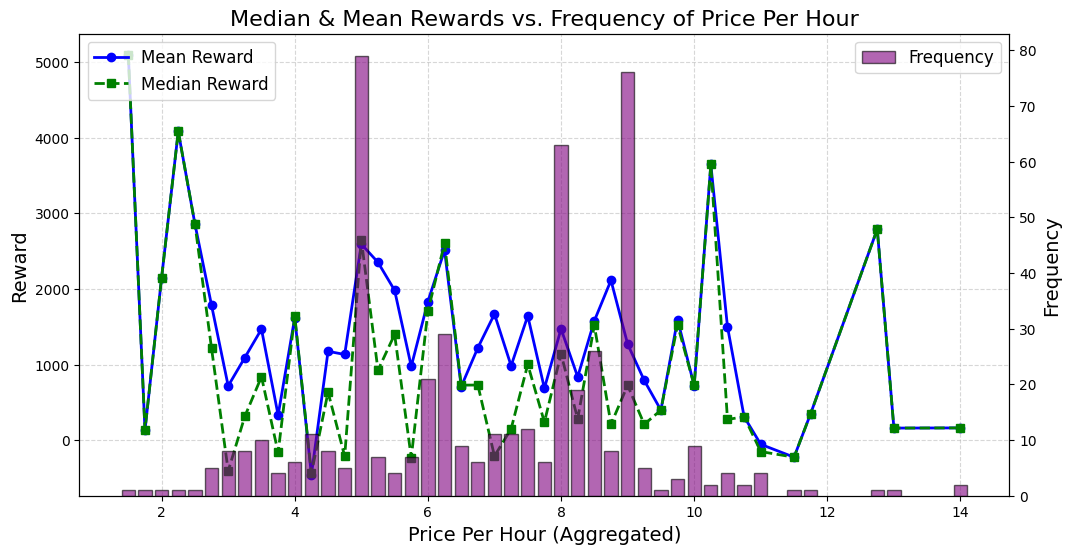

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dual_axis_rewards_and_frequency(aggregated_rewards):
    """
    Plot a dual-axis graph showing median and average rewards on the primary axis
    and frequency on the secondary axis for aggregated price per hour bins.

    Parameters:
    aggregated_rewards (dict): A dictionary where keys are binned prices per hour,
                               and values are lists of rewards.
    """

    prices_per_hour = sorted(aggregated_rewards.keys())
    mean_rewards = [np.mean(aggregated_rewards[price]) for price in prices_per_hour]
    median_rewards = [np.median(aggregated_rewards[price]) for price in prices_per_hour]
    frequencies = [len(aggregated_rewards[price]) for price in prices_per_hour]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(prices_per_hour, mean_rewards, label='Mean Reward', marker='o', color='blue', linewidth=2)
    ax1.plot(prices_per_hour, median_rewards, label='Median Reward', marker='s', color='green', linestyle='--', linewidth=2)
    ax1.set_xlabel('Price Per Hour (Aggregated)', fontsize=14)
    ax1.set_ylabel('Reward', fontsize=14)
    ax1.set_title('Median & Mean Rewards vs. Frequency of Price Per Hour', fontsize=16)
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    ax1.legend(loc='upper left', fontsize=12)

    ax2 = ax1.twinx()
    ax2.bar(prices_per_hour, frequencies, width=0.2, color='purple', alpha=0.6, label='Frequency', edgecolor='black')
    ax2.set_ylabel('Frequency', fontsize=14)
    ax2.legend(loc='upper right', fontsize=12)

    plt.show()
plot_dual_axis_rewards_and_frequency(aggregated_rewards)
